In [35]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

In [38]:
Root = tfd.JointDistributionCoroutine.Root

def probabilistic_pca(data_dim, latent_dim, num_datapoints, stddv_datapoints):
    w = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
                 scale=3.0 * tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=2.0*tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    x_original = yield tfd.Independent(tfd.Normal(
        loc=tf.matmul(w, z),
        scale=stddv_datapoints,
        name="x"), reinterpreted_batch_ndims=2)

In [39]:
num_datapoints = 5000
data_dim = 2
latent_dim = 1
stddv_datapoints = 0.5

concrete_ppca_model = functools.partial(probabilistic_pca,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints,
    stddv_datapoints=stddv_datapoints)

model = tfd.JointDistributionCoroutine(concrete_ppca_model)


In [42]:
actual_w, actual_z, x_train = model.sample()

print("Principal axes:")
print(actual_w)
print(actual_z)

Principal axes:
tf.Tensor(
[[-2.026372 ]
 [ 1.9205436]], shape=(2, 1), dtype=float32)
tf.Tensor(
[[ 2.9300754   1.3287492   2.9274626  ... -0.12263768  0.3983372
  -2.9232886 ]], shape=(1, 5000), dtype=float32)


No handles with labels found to put in legend.


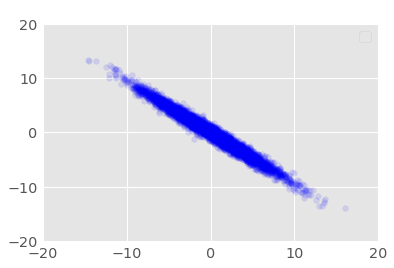

In [43]:
plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1)
plt.axis([-20, 20, -20, 20])
plt.legend()
plt.title("Data set")
plt.show()

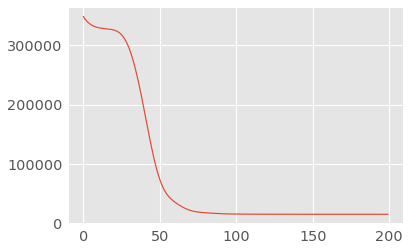

In [44]:
w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

target_log_prob_fn = lambda w, z: model.log_prob((w, z, x_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(w, z),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=200)
plt.plot(losses)
plt.show()

MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 2.5760117],
       [-2.4487722]], dtype=float32)>


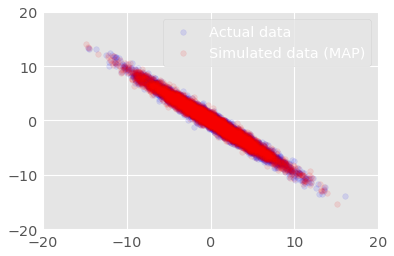

In [45]:
print("MAP-estimated axes:")
print(w)

_, _, x_generated = model.sample(value=(w, z, None))

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()

# Variational Inference

In [48]:
qw_mean = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
qz_mean = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([data_dim, latent_dim]), dtype=tf.float32))
qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, num_datapoints]), dtype=tf.float32))
def factored_normal_variational_model():
    qw = yield Root(tfd.Independent(tfd.Normal(
      loc=qw_mean, scale=qw_stddv, name="qw"), reinterpreted_batch_ndims=2))
    qz = yield Root(tfd.Independent(tfd.Normal(
      loc=qz_mean, scale=qz_stddv, name="qz"), reinterpreted_batch_ndims=2))

surrogate_posterior = tfd.JointDistributionCoroutine(
    factored_normal_variational_model)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn,
    surrogate_posterior=surrogate_posterior,
    optimizer=tf.optimizers.Adam(learning_rate=0.05),
    num_steps=200)

Inferred axes:
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 2.5752466],
       [-2.4408257]], dtype=float32)>
Standard Deviation:
tf.Tensor(
[[0.01814996]
 [0.01814996]], shape=(2, 1), dtype=float32)


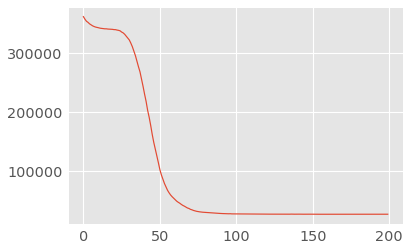

In [49]:
print("Inferred axes:")
print(qw_mean)
print("Standard Deviation:")
print(qw_stddv)

plt.plot(losses)
plt.show()

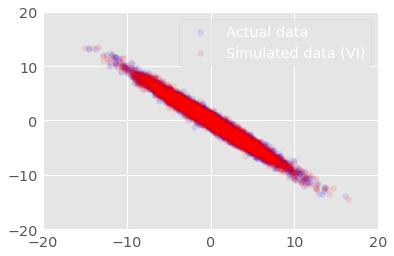

In [50]:
posterior_samples = surrogate_posterior.sample(50)
_, _, x_generated = model.sample(value=(posterior_samples))

# It's a pain to plot all 5000 points for each of our 50 posterior samples, so
# let's subsample to get the gist of the distribution.
x_generated = tf.reshape(tf.transpose(x_generated, [1, 0, 2]), (2, -1))[:, ::47]

plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (VI)')
plt.legend()
plt.axis([-20, 20, -20, 20])
plt.show()